<a href="https://colab.research.google.com/github/tm-hoangnguyen/Credit-Card-Attrition-Prediction/blob/main/attrition_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Import Libraries </h2>

We will use the PyTorch to develop a neural network model for this project

In [1]:
import pandas as pd
import numpy as np
import torch
import kagglehub
import os
import tqdm # to see epoch update
import torch.nn as nn
import torch.optim as optim
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics import MatthewsCorrCoef


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

<h2> Get data from Kaggle </h2>


The dataset is from https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data. It contains variables on customer demographics and credit card spending habits. This work involves exploring and analyzing the data to develop statistical models for predicting customer attrition.

In [ ]:
# remove corrupted file

# dataset_path = "/root/.cache/kagglehub/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/versions/3/BankChurners.csv"

# if os.path.exists(dataset_path):
#     os.remove(dataset_path)

In [2]:
# load from kagglehub
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "thedevastator/predicting-credit-card-customer-attrition-with-m",
  "BankChurners.csv",
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print('cuda' if torch.cuda.is_available() else 'cpu')


<ipython-input-2-04316f1d6731>:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|██████████| 379k/379k [00:00<00:00, 994kB/s]

Extracting zip of BankChurners.csv...
cuda


The dataset includes the following variables (from the source). Two naive classifier columns will not be used in this analysis.

- **CLIENTNUM**: Unique identifier for each customer (Integer).
- **Attrition_Flag**: Indicates whether the customer has churned (Boolean).
- **Customer_Age**: Age of the customer (Integer).
- **Gender**: Gender of the customer (String).
- **Dependent_count**: Number of dependents the customer has (Integer).
- **Education_Level**: Education level of the customer (String).
- **Marital_Status**: Marital status of the customer (String).
- **Income_Category**: Income category of the customer (String).
- **Card_Category**: Type of card held by the customer (String).
- **Months_on_book**: Duration the customer has been with the provider (Integer).
- **Total_Relationship_Count**: Total number of relationships the customer has with the credit card provider (Integer).
- **Months_Inactive_12_mon**: Number of months the customer has been inactive in the last 12 months (Integer).
- **Contacts_Count_12_mon**: Number of contacts the customer has had in the last 12 months (Integer).
- **Credit_Limit**: Customer’s credit limit (Integer).
- **Total_Revolving_Bal**: Total revolving balance of the customer (Integer).
- **Avg_Open_To_Buy**: Average open-to-buy ratio of the customer (Integer).
- **Total_Amt_Chng_Q4_Q1**: Change in total amount spent from Q4 to Q1 (Integer).
- **Total_Trans_Amt**: Total transaction amount (Integer).
- **Total_Trans_Ct**: Total transaction count (Integer).
- **Total_Ct_Chng_Q4_Q1**: Change in transaction count from Q4 to Q1 (Integer).
- **Avg_Utilization_Ratio**: Average utilization ratio of the customer (Integer).


In [3]:
pd.set_option('display.max_columns', None)

print("Data Types: \n")
print(df.dtypes.sort_values())

df.head()

Data Types: 

CLIENTNUM                                                                                                                               int64
Total_Trans_Ct                                                                                                                          int64
Total_Trans_Amt                                                                                                                         int64
Total_Revolving_Bal                                                                                                                     int64
Contacts_Count_12_mon                                                                                                                   int64
Total_Relationship_Count                                                                                                                int64
Months_on_book                                                                                                                        

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


<h2> Exploratory Data Analysis </h2>

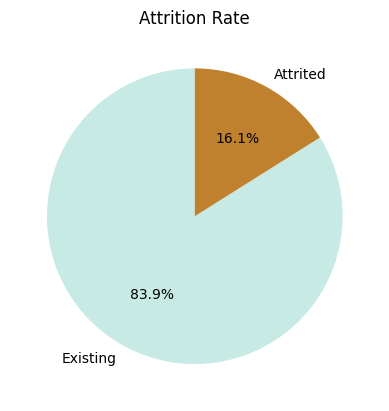

In [4]:
import warnings
warnings.filterwarnings("ignore")

# check class balance
existing_count = df['Attrition_Flag'].value_counts()[0] / len(df) * 100
attrited_count = df['Attrition_Flag'].value_counts()[1] / len(df) * 100

colors = sns.color_palette("BrBG", 4)

plt.pie([existing_count, attrited_count], labels=['Existing', 'Attrited'], autopct='%1.1f%%', startangle=90, colors=[colors[2], colors[0]])
plt.title('Attrition Rate')
plt.show()



The dataset is skewed, with more existing customers (83.9%) than attrited ones (16.1%). The imbalance could make it harder for models to detect churn, so it’s something to keep in mind when analyzing the data.

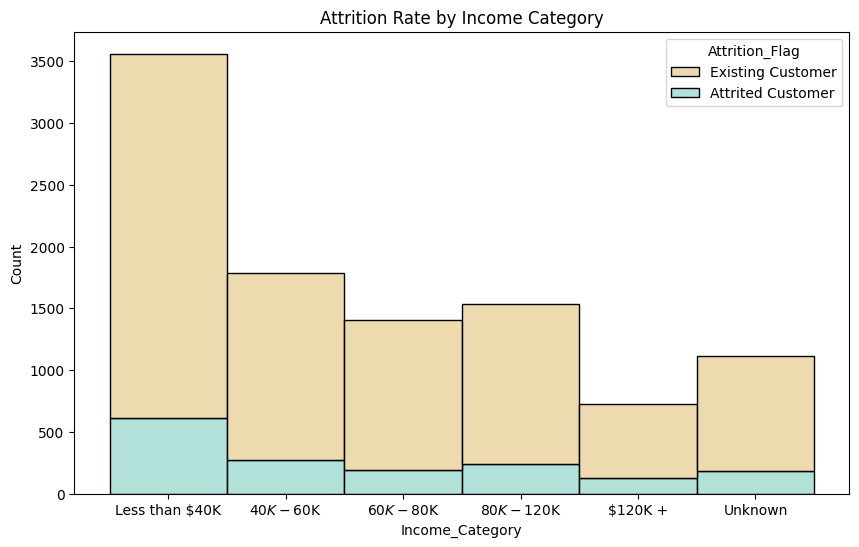

In [7]:
df_plot = df.copy()

income_order = ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +', 'Unknown']
df_plot['Income_Category'] = pd.Categorical(df_plot['Income_Category'], categories=income_order, ordered=True)

plt.figure(figsize=(10, 6))
sns.histplot(
    x=df_plot['Income_Category'],
    hue=df_plot['Attrition_Flag'],
    palette='BrBG',
    multiple='stack'
)
plt.title('Attrition Rate by Income Category')
plt.show()


Customers in the "Less than $40K" income category make up the largest share of the dataset and exhibit the highest attrition rate. This suggests a potential relationship between lower income levels and a higher likelihood of churn.

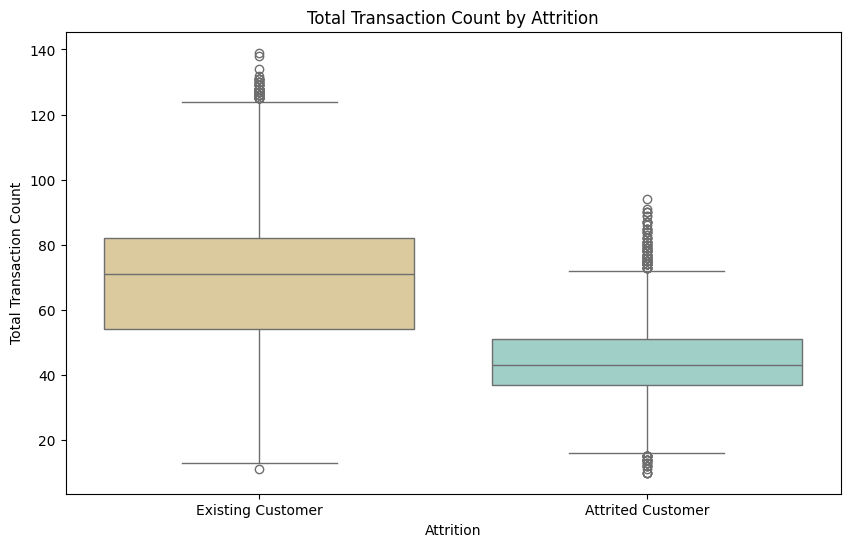

In [ ]:
# total transaction count box plot
trans_analysis = df[['Total_Trans_Ct', 'Attrition_Flag']]

plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Ct', data=trans_analysis, palette='BrBG')
plt.title('Total Transaction Count by Attrition')
plt.xlabel('Attrition')
plt.ylabel('Total Transaction Count')
plt.show()


Attrited customers tend to have lower total transaction counts compared to existing customers. The median transaction count for attrited customers is lower, and their overall range of transaction counts is narrower compared to existing customers, indicating that lower engagement may be a strong predictor of attrition.

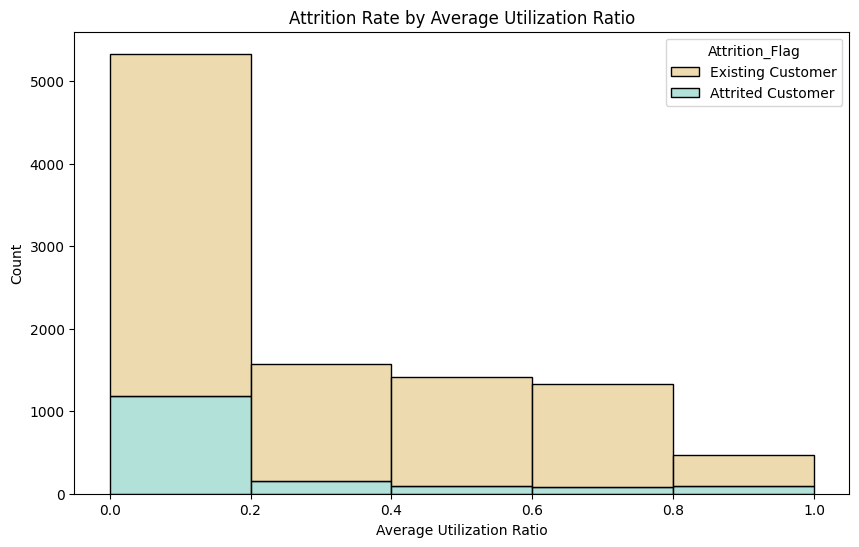

In [ ]:
# histogram to show average utilization ratio group

# groups into bins with 0.2 unit, range from 0 to 1
bins = np.arange(0, 1.2, 0.2)

plt.figure(figsize=(10, 6))
sns.histplot(x=df['Avg_Utilization_Ratio'], bins=bins, hue=df['Attrition_Flag'], palette='BrBG', multiple='stack')
plt.title('Attrition Rate by Average Utilization Ratio')
plt.xlabel('Average Utilization Ratio')
plt.show()


Customer attrition is concentrated at lower utilization ratios, particularly in the 0.0-0.2 range. As utilization ratios increase from 0.2 to 1, the proportion of attrited customers decreases while existing customers maintain a more consistent presence across all utilization levels, though with declining numbers at higher ratios.

<h2> Processing Data </h2>

Since there are 3 variables with Unknown values, we will make it as a category in Marital_Status. Mode will be applied for Education_Level and Income_Category because the data is ordinal

In [ ]:
## replace Unknown values ##

df_process = df.copy()

## drop columns ##

# drop id
df_process = df_process.drop(['CLIENTNUM'], axis=1)

# drop 2 Naive Bayes columns
df_process = df_process.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
            'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)


# identify rows with Unknown values
for each in df_process.columns:
    if df_process[each].eq('Unknown').any() == True:
        print(each, '- include', len(df_process[df_process[each] == 'Unknown']), 'Unknown values')

# replace Unknown values from Education_Level and Income_Category to mode
df_process['Education_Level'] = df_process['Education_Level'].replace('Unknown', df_process['Education_Level'].mode()[0])
df_process['Income_Category'] = df_process['Income_Category'].replace('Unknown', df_process['Income_Category'].mode()[0])

print('\n')
print('Value Count after Replacement:')
print(df_process['Education_Level'].value_counts(), '\n')
print(df_process['Income_Category'].value_counts())


Education_Level - include 1519 Unknown values
Marital_Status - include 749 Unknown values
Income_Category - include 1112 Unknown values


Value Count after Replacement:
Education_Level
Graduate         4647
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64 

Income_Category
Less than $40K    4673
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
$120K +            727
Name: count, dtype: int64


Next step is encoding categorical variables: Card_Category, Education_Level, Income_Category, Marital_Status, Gender. Since Card_Category, Education_Level, and Income_Category are ordinal, we can encode them with ordered numerical values. For nominal variables like Marital_Status and Gender, we will use dummies.

In [ ]:
## scaling ##

# scale data to [0, 1] for ML training
columns_to_scale = ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'Contacts_Count_12_mon', 'Contacts_Count_12_mon',
                    'Total_Relationship_Count', 'Months_on_book', 'Months_Inactive_12_mon', 'Dependent_count', 'Customer_Age',
                    'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

scaler = MinMaxScaler()
df_process[columns_to_scale] = scaler.fit_transform(df_process[columns_to_scale])

## encoding categorical data ##

# ordinal (Card_Category, Education_Level, Income Category)
card_category_order = ['Blue', 'Silver', 'Gold', 'Platinum']
education_level_order = ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']
income_category_order = ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']

card_category_encoder = OrdinalEncoder(categories=[card_category_order])
education_level_encoder = OrdinalEncoder(categories=[education_level_order])
income_category_encoder = OrdinalEncoder(categories=[income_category_order])

df_process[['Card_Category']] = card_category_encoder.fit_transform(df_process[['Card_Category']])
df_process[['Education_Level']] = education_level_encoder.fit_transform(df_process[['Education_Level']])
df_process[['Income_Category']] = income_category_encoder.fit_transform(df_process[['Income_Category']])

# nominal (Marital_Status, Gender)
onehot_encoder = OneHotEncoder(sparse_output=False) ## include 0s

encoded_data = onehot_encoder.fit_transform(df_process[['Marital_Status', 'Gender']])

encoded_names = onehot_encoder.get_feature_names_out(['Marital_Status', 'Gender'])

encoded_df = pd.DataFrame(encoded_data, columns=encoded_names)

df_process = pd.concat([df_process, encoded_df], axis=1)

# map target var (Attrition_Flag to 0 and 1)
mapping_attrition = {'Existing Customer': 0, 'Attrited Customer': 1}
df_process['Attrition_Flag'] = df_process['Attrition_Flag'].map(mapping_attrition)

# drop 2 columns
df_process = df_process.drop(['Marital_Status', 'Gender'], axis=1)


In [ ]:
df_process.head()

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Gender_F,Gender_M
0,0,0.404255,0.6,1.0,2.0,0.0,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,0.392994,0.035273,0.248062,0.437534,0.061061,0.0,1.0,0.0,0.0,0.0,1.0
1,0,0.489362,1.0,3.0,0.0,0.0,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,0.453636,0.043452,0.178295,1.000000,0.105105,0.0,0.0,1.0,0.0,1.0,0.0
2,0,0.531915,0.6,3.0,3.0,0.0,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,0.763615,0.076611,0.077519,0.628164,0.000000,0.0,1.0,0.0,0.0,0.0,1.0
3,0,0.297872,0.8,1.0,0.0,0.0,0.488372,0.4,0.666667,0.166667,0.056676,1.000000,0.022977,0.413600,0.036775,0.077519,0.628164,0.760761,0.0,0.0,0.0,1.0,1.0,0.0
4,0,0.297872,0.6,0.0,2.0,0.0,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,0.640271,0.017025,0.139535,0.673129,0.000000,0.0,1.0,0.0,0.0,0.0,1.0


<h3> Load data to Pytorch </h3>

The following code splits the dataset into features and targets (Attrition_Flag). It then splits the data into training and testing sets (80/20) using train_test_split. Finally, the features and target values are converted to PyTorch tensors for model training.

In [ ]:
# split to X and y
X = df_process.drop(['Attrition_Flag'], axis=1).values # convert to numpy (10127, 23)
y = df_process['Attrition_Flag'].values #(10127,)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert to tensors
X_train_ts = torch.tensor(X_train, dtype=torch.float32)
X_test_ts = torch.tensor(X_test, dtype=torch.float32)
y_train_ts = torch.tensor(y_train, dtype=torch.float32)
y_test_ts = torch.tensor(y_test, dtype=torch.float32)



Custom ChurnDataset class for PyTorch is created.

In [ ]:
class ChurnDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# initialize dataset
train_dataset = ChurnDataset(X_train_ts, y_train_ts)
test_dataset = ChurnDataset(X_test_ts, y_test_ts)

Now we create data loaders for the training and testing datasets with a batch size of 64. The training data is shuffled, while the testing data is not.

In [ ]:
## initiate data loader ##
train_ts_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_ts_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### Binary Classification Model

The model consists of multiple layers:

- **Linear**: these perform linear transformations, learning weights and biases during training.
- **ReLU**: an activation function that outputs values between 0 and infinity, helping with feature selection.
- **Dropout**: a regularization technique that randomly drops connections between layers to prevent overfitting.
- **Output Layer**: a final linear layer that outputs a single value for binary classification, with BCEWithLogitsLoss handling the sigmoid internally.

The network starts with larger layers and gradually reduces in size, condensing the information until the final output.


In [ ]:
## implement Binary Classification Model ##

class deep_model(nn.Module):
    def __init__(self, input_size): # 3 layers
        super().__init__()
        self.layer1 = nn.Linear(input_size, 64) # input size: 23
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        # not use sigmoid since using BCEWithLogitsLoss function

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)

        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.relu3(x)

        x = self.output(x)
        return x


<h2> Train Model </h2>

The following code trains and tests the model. When running the function, we can define the following parameters:

- **model**: The neural network to be trained.
- **train_loader**: DataLoader for training, providing batches of training data.
- **test_loader**: DataLoader for testing, providing batches of test data.
- **num_epochs**: The number of epochs to train the model.
  
The training process include:

- **Loss Function**: Binary Cross-Entropy with Logits (BCEWithLogitsLoss), which combines the sigmoid function and binary cross-entropy loss. It handles imbalanced classes using a positive weight.
  
- **Optimizer**: Adam optimizer with a learning rate of 0.01 and weight decay of 0.001 to update model parameters.

- **Metrics**: Accuracy and Matthews Correlation Coefficient (MCC) are used to evaluate the model's performance.

The training process tracks the best model based on test accuracy and loads the best weights for final evaluation. It also prints the training time at the end.



In [ ]:
## train model ##

def train_model(model, train_loader, test_loader, num_epochs):

    # move data to gpu
    model.to('cuda')
    # X_train = X_train.to('cuda')
    # y_train = y_train.to('cuda')
    # X_test = X_test.to('cuda')
    # y_test = y_test.to('cuda')

    mcc = MatthewsCorrCoef(task='binary').to('cuda')

    # initialize without cuda
    # mcc = MatthewsCorrCoef(task='binary')

    # optimizer - Adam
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

    # compute pos weight to solve imbalance
    unique, counts = np.unique(y, return_counts=True)
    pos_weight = counts[0] / counts[1]

    # loss function - Binary Cross Entropy w logit loss
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to('cuda'))

    # loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

    # initialize scores
    best_acc = -np.inf
    best_weights = None

    # track time
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()

        with tqdm.tqdm(train_loader, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for X_batch, y_batch in bar:
                X_batch = X_batch.to('cuda')
                y_batch = y_batch.to('cuda')

                # pass function
                y_pred = model(X_batch)


                # compute loss
                y_batch = y_batch.unsqueeze(dim=1)
                loss = loss_fn(y_pred, y_batch)

                # backpropagation
                optimizer.zero_grad() # clear gradients
                loss.backward()

                # update
                optimizer.step()

                # print bar
                pred_sigmoid = (torch.sigmoid(y_pred) > 0.5).float()
                acc = (pred_sigmoid == y_batch).float().mean()

                # mcc
                mcc_score = mcc(pred_sigmoid, y_batch)


                bar.set_postfix(
                    loss=float(loss),
                    acc=f"{float(acc):.3f}",
                    mcc= f"{float(mcc_score):.3f}"
                )

        # accuracy evaluation
        model.eval()

        # get the test data from test_loader
        X_test = test_loader.dataset.X
        y_test = test_loader.dataset.y

        X_test = X_test.to('cuda')
        y_test = y_test.to('cuda')

        with torch.no_grad():
            y_pred = model(X_test)
            y_pred = y_pred.squeeze(dim=1)
            predictions = (torch.sigmoid(y_pred) > 0.5).float()
            acc = (predictions == y_test).float().mean()


        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_weights)

    print(f"train time: {round(time.time() - start_time, 2)}s")


    return best_acc




Set seed, initialize the model, train it for 200 epochs

In [ ]:
# set seed
torch.manual_seed(79)

model = deep_model(input_size=X_train_ts.shape[1]).to('cuda')

num_epochs = 200

trained_acc = train_model(model, train_ts_loader, test_ts_loader, num_epochs)

print(trained_acc*100)

Epoch 199: 100%|██████████| 127/127 [00:01<00:00, 113.61batch/s, acc=0.973, loss=0.073, mcc=0.920]


train time: 214.15s
tensor(93.3366, device='cuda:0')


The model achieves strong performance with 93.3% test accuracy and occasional perfect training results, demonstrating its learning capability. But it exhibits instability in training with random fluctuations in loss and accuracy metrics, likely due to the small dataset size making it prone to overfitting.